In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve


### ПУНКТ 1

In [19]:
def solve_heat_equation(T: float, L: float, Nt: int, Nx: int, b: float, u0):
    """Сеточное решение уравнения u_t = u_xx + b*u с нулевыми краевыми условиями
    
    Args:
        T (float):
            Конечная точка временного отрезка [0, T]
        L (float):
            Конечная точка пространственного отрезка [0, L]
        Nt (int):
            Количество шагов по времени
        Nx (int):
            Количество узлов по пространству
        b (float):
            Коэффициент добавки '+ b u'
        u0:
            Начальное условие (функция или массив)
    """
    # Шаги сетки
    dt = T / Nt
    dx = L / (Nx - 1)
    r = dt / (dx * dx) # число для удобства записи схемы
    
    # Создание сетки
    x = np.linspace(0, L, Nx)
    t = np.linspace(0, T, Nt + 1)
    
    # Матрица решения
    u = np.zeros((Nt + 1, Nx)) # строки — временные слои, столбцы — пространственные узлы
    
    # Начальное условие
    if callable(u0):
        u[0, :] = u0(x)
    else:
        u[0, :] = u0
    
    # Коэффициенты для метода прогонки (для всех точек!)
    # Для системы размером (Nx)x(Nx)
    system_size = Nx
    
    # Коэффициенты ленточной матрицы
    a_coef = np.full(system_size, -r)               # нижняя диагональ
    b_coef = np.full(system_size, 1 + 2*r - b*dt)   # главная диагональ
    c_coef = np.full(system_size, -r)               # верхняя диагональ
    
    # Корректировка для первой и последней строк системы
    # (учитываем краевые условия)
    c_coef[0] = -r       # остается
    a_coef[-1] = -r      # остается
    
    # Шагаем по слоям
    for n in tqdm(range(Nt), desc="Решение"):
        # Правая часть системы
        f_coef = u[n, 1:-1].copy()
        
        # Метод прогонки для внутренних точек
        u_algo = thomas_algorithm(a_coef, b_coef, c_coef, f_coef)
        
        # Восстанавливаем краевое условие (вдруг, мы подпортили)
        u[n+1, 0] = 0.0         # левое краевое условие
        u[n+1, 1:-1] = u_algo   # внутренние точки
        u[n+1, -1] = 0.0        # правое краевое условие
    
    return t, x, u

def thomas_algorithm(a, b, c, f):
    """
    Метод прогонки для трехдиагональной системы
    Система: a[i]*x[i-1] + b[i]*x[i] + c[i]*x[i+1] = f[i]
    """
    n = len(f)
    
    # Проверка размеров
    if n == 0:
        return np.array([])
    
    # Вспомогательные массивы под коэффициенты alpha и beta
    alpha = np.zeros(n)
    beta = np.zeros(n)
    x = np.zeros(n)
    
    # Прямой ход метода
    alpha[0] = -c[0] / b[0]
    beta[0] = f[0] / b[0]
    
    for i in range(1, n):
        denominator = b[i] + a[i] * alpha[i-1]
        alpha[i] = -c[i] / denominator
        beta[i] = (f[i] - a[i] * beta[i-1]) / denominator
    
    # Обратный ход метода
    x[-1] = beta[-1]
    
    for i in range(n-2, -1, -1):
        x[i] = alpha[i] * x[i+1] + beta[i]
    
    return x

In [20]:
def plot_solution(t, x, u, main_title='Эволюция решения уравнения теплопроводности'):
    """
    Визуализация решения в 2D и 3D
    
    Args:
        t (np.array): 
            Временная сетка
        x (np.array): 
            Пространственная сетка
        u (2d-array): 
            Матрица решения [время, пространство]
        title (str): 
            Заголовок графика поверхности
    """

    Nt = len(t)-1
    
    # Создаем фигуру с двумя subplots
    fig = plt.figure(figsize=(15, 6))

    # 2D график - эволюция решения
    plt.subplot(1, 2, 1)
    for i in range(0, Nt+1, max(1, Nt//5)):
        plt.plot(x, u[i, :], label=f't={t[i]:.3f}')
    plt.xlabel('x')
    plt.ylabel('$u(x, t)$')
    plt.legend()
    plt.title('Эволюция решения')
    plt.grid(True)

    # 3D визуализация
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    
    X_grid, T_grid = np.meshgrid(x, t)
    surf = ax.plot_surface(X_grid, T_grid, u, cmap='coolwarm', 
                          alpha=0.9, antialiased=True)

    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('$u(x, t)$')
    ax.set_title('3D визуализация решения')

    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=20)

    plt.suptitle(main_title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [21]:
def initial_condition(x):
    """Начальное условие: sin(pi*x)"""
    
    return np.sin(np.pi * x)

In [22]:
# Параметры
T = 1.0                 # Конечное время
L = 1.0                 # Длина области
Nt = 100                # Шаги по времени
Nx = 101                # Узлы по пространству
b = np.pi*np.pi + 1.0   # Коэффициент в уравнении

Решение: 100%|██████████| 100/100 [00:00<00:00, 3715.00it/s]


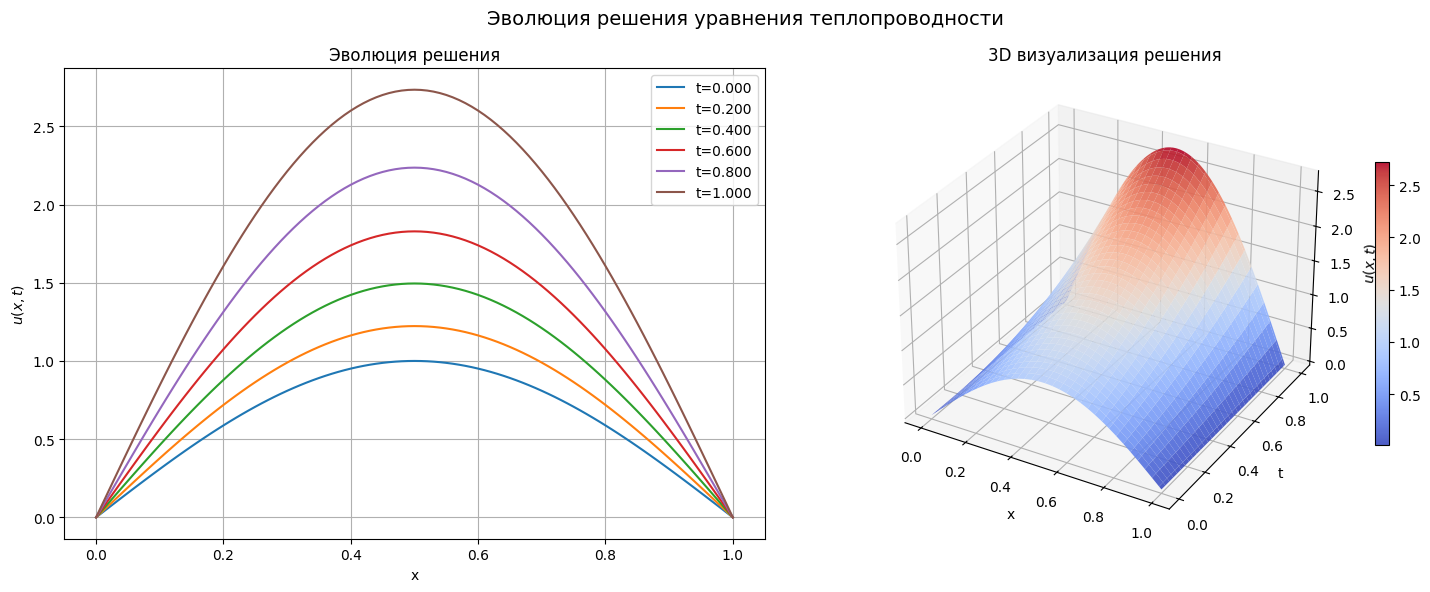

In [23]:
t, x, u = solve_heat_equation(T, L, Nt, Nx, b, initial_condition)

plot_solution(t, x, u)


### ПУНКТ 2

In [24]:
def add_condition(x):
    """Добавка
       Возвращает функцию, которая равна: sin(πx) на отрезке [0.25, 0.75] и 0 вне этого отрезка
    """

    x = np.asarray(x)
    return np.where((x >= 0.25) & (x <= 0.75), np.sin(np.pi * x), 0.0)

def scalar_product(mas1: np.array, mas2: np.array, L: float = 1.0):
    """Сеточное скалярное произведение.

    Args:
        mas1 (np.array): 
            первый массив значений функции
        mas2 (np.array): 
            второй массив значений функции  
        L (float): 
            длина отрезка (по умолчанию 1.0)
    """
    return np.sum(mas1 * mas2) * (L / (len(mas1) - 1))

def orthogonal_coefficient(x, L=1.0):
    """
        Находит коэффициент d1 такой, что u0 = initial_condition + d1 * add_condition ортогонально initial_condition
        d1 = - (<initial_condition, initial_condition>) / (<add_condition, initial_condition>)
    """
    # Вычисляем значения функций на сетке
    u0_vals = initial_condition(x)
    add_vals = add_condition(x)

    # ОТНОСИТЕЛЬНО СИНУСОВОЙ БАЗИСНОЙ ФУНКЦИИ
    basis_function = np.sin(np.pi * x)
    
    # Вычисляем скалярные произведения
    u0_u0 = scalar_product(u0_vals, basis_function, L)
    add_u0 = scalar_product(add_vals, basis_function, L)
    
    # Вычисляем коэффициент d1
    d1 = -u0_u0 / add_u0
    
    return d1, u0_vals, add_vals

# Функция для создания ортогонального начального условия
def orthogonal_initial_condition(x, L=1.0):
    """
    Создаёт ортогональное начальное условие u0 = initial_condition + d1 * add_condition
    """
    d1, u0_vals, add_vals = orthogonal_coefficient(x, L)
    u0_orthogonal = u0_vals + d1 * add_vals
    
    return u0_orthogonal

In [25]:
# Параметры
T = 1.0      # Конечное время
L = 1.0      # Длина области
Nt = 200     # Шаги по времени
Nx = 1001     # Узлы по пространству
b = np.pi*np.pi + 1.0      # Коэффициент в уравнении

Решение: 100%|██████████| 200/200 [00:00<00:00, 1485.40it/s]


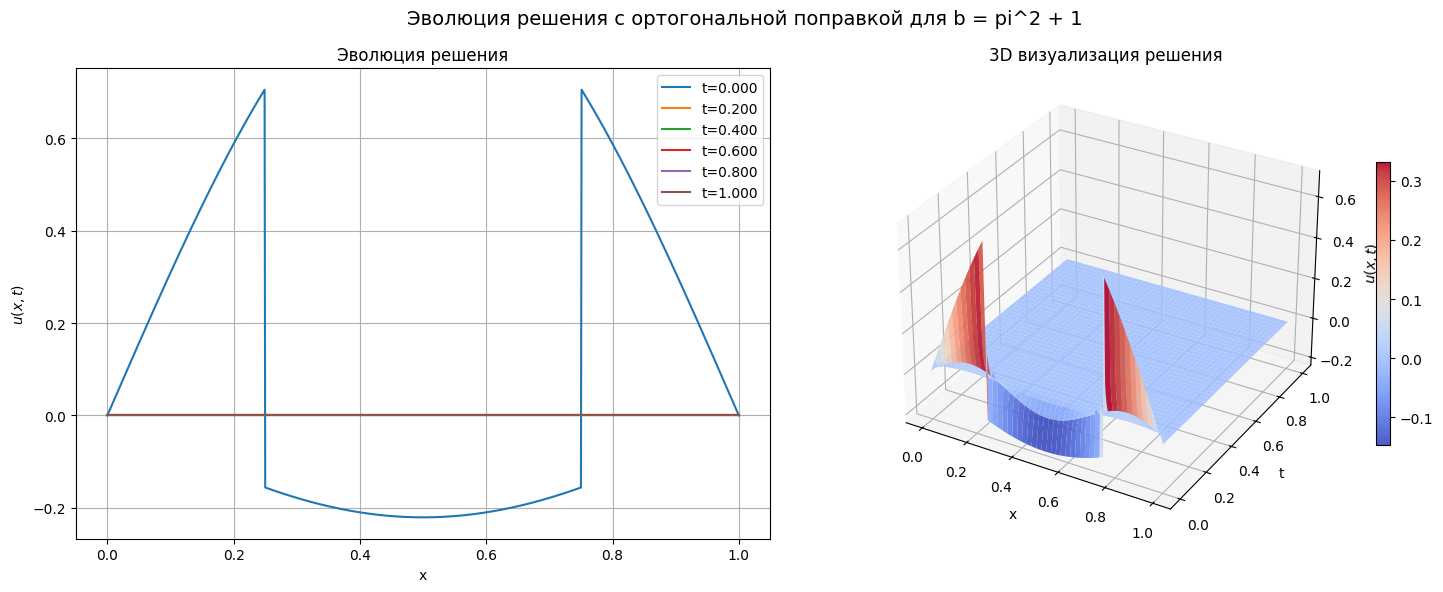

In [26]:
t, x, u = solve_heat_equation(T, L, Nt, Nx, b, orthogonal_initial_condition)

plot_solution(t, x, u, main_title='Эволюция решения с ортогональной поправкой для b = pi^2 + 1')


Решение: 100%|██████████| 200/200 [00:00<00:00, 1430.87it/s]


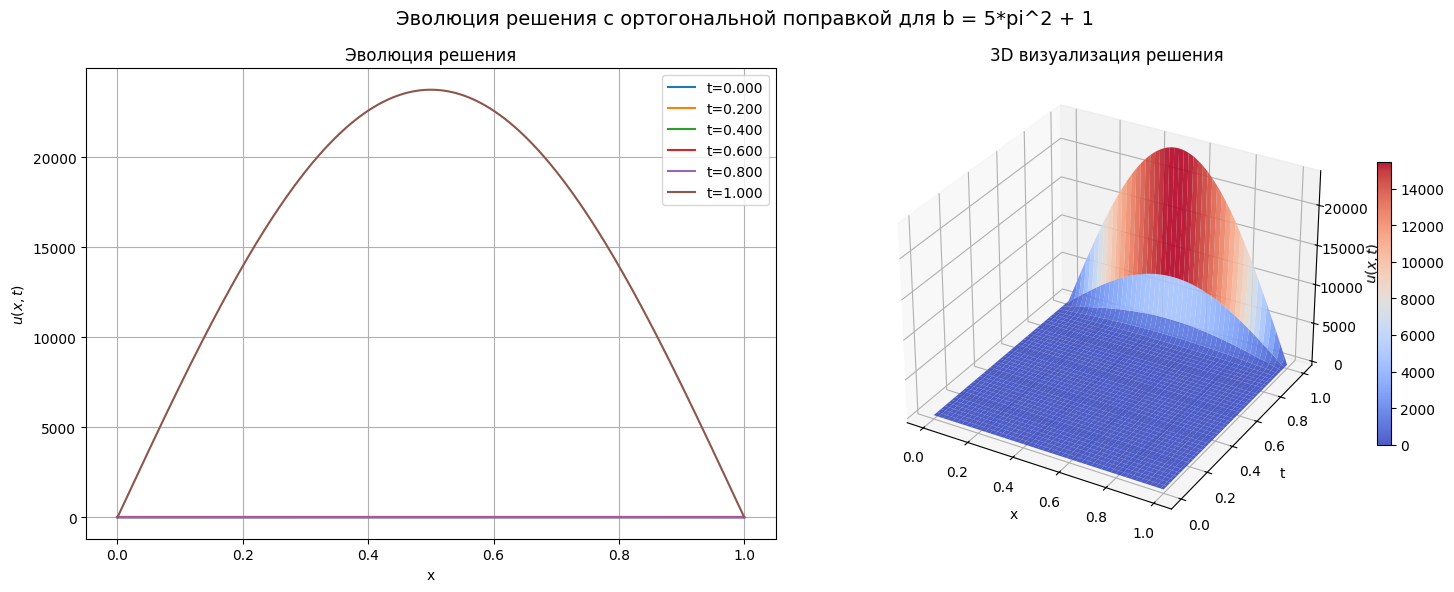

In [27]:
b = 5*np.pi*np.pi + 1.0      # Коэффициент в уравнении

t, x, u = solve_heat_equation(T, L, Nt, Nx, b, orthogonal_initial_condition)

plot_solution(t, x, u, main_title='Эволюция решения с ортогональной поправкой для b = 5*pi^2 + 1')


### ПУНКТ 3

In [ ]:
def orthogonal_coefficients(x, add_conditions, basis_functions, L=1.0):
    """
    Находит коэффициенты d такие, что u0 = initial_condition + sum(d_i * add_conditions_i) 
    ортогонально всем basis_functions через нахождение решения системы: <u0, basis_j> = 0 для всех j
    """

    # Вычисляем значения функций на сетке
    u0_vals = initial_condition(x)
    add_vals = [add_cond(x) for add_cond in add_conditions]
    basis_vals = [basis_func(x) for basis_func in basis_functions]
    
    n = len(add_conditions)
    m = len(basis_functions)
    
    # Создаём матрицу системы A и правую часть b
    A = np.zeros((m, n))
    b = np.zeros(m)
    
    # Заполняем матрицу A и вектор b
    for j in range(m):
        b[j] = -scalar_product(u0_vals, basis_vals[j], L)
        for i in range(n):
            A[j, i] = scalar_product(add_vals[i], basis_vals[j], L)
    
    # Решаем систему линейных уравнений
    if m == n:  # Квадратная система
        d = np.linalg.solve(A, b)
    else:       # Переопределенная или недоопределенная система (через МНК)
        d = np.linalg.lstsq(A, b, rcond=None)[0]
    
    return d, u0_vals, add_vals, basis_vals

def orthogonal_initial_condition(x, add_conditions, basis_functions, L=1.0):
    """Создаёт ортогональное начальное условие u0 = initial_condition + sum(d_i * add_conditions_i)"""

    d, u0_vals, add_vals, _ = orthogonal_coefficients(x, add_conditions, basis_functions, L)
    
    # Строим линейную комбинацию
    u0_orthogonal = u0_vals.copy()
    for i in range(len(d)):
        u0_orthogonal += d[i] * add_vals[i]
    
    return u0_orthogonal

def find_unstable_modes(b, max_k=30):
    """
        Находит нестабильные гармоники для заданного b
        b > (πk)² → λ > 0 → гармоника растет
        b < (πk)² → λ < 0 → гармоника затухает
    """

    unstable_modes = []
    for k in range(1, max_k + 1):
        if b > (np.pi * k)**2:
            unstable_modes.append(k)
    return unstable_modes

def garmonic_k(x, k):
    return np.where((x >= 0.25) & (x <= 0.75), np.sin(np.pi * k * x), 0.0)

def create_unstable_system(x, b, L=1.0, max_k=2):
    """Создаёт систему для нестабильных гармоник"""

    # Находим нестабильные гармоники
    unstable_modes = find_unstable_modes(b, max_k)
    m = len(unstable_modes)
    print(f"Нестабильных гармоник: m = {m}, k = {unstable_modes}")
    
    if m == 0:      # Нестабильных гармоник нет
        return initial_condition(x), [], []
    
    # Создаём добавки и базисные функции для нестабильных гармоник
    add_conditions  = [lambda x, k=k: garmonic_k(x, k) for k in unstable_modes]
    basis_functions = [lambda x, k=k: np.sin(np.pi * k * x) for k in unstable_modes]
    
    # Находим поправленное (ортогональное) начальное условие
    u0_orthogonal = orthogonal_initial_condition(x, add_conditions, basis_functions, L)
    
    # Проверяем ортогональность
    basis_vals = [basis_func(x) for basis_func in basis_functions]
    for j, basis_val in enumerate(basis_vals):
        product = scalar_product(u0_orthogonal, basis_val, L)
        # print("scalar product = ", product)
        # print(f"<u0_orthogonal, basis{j}> = {product:.2e}")
    
    return u0_orthogonal

def decompose_into_harmonics(u0_vals, x, num_harmonics, L=1.0):
    """Разложение функции по гармоникам"""
    
    coeffs = []
    
    for k in range(1, num_harmonics + 1):
        ph = np.sin(np.pi * k * x)
        num = scalar_product(u0_vals, ph, L)
        denom = scalar_product(ph, ph, L)
        c_k = num / denom
        coeffs.append(c_k)
    
    print("\nКоэффициенты разложения по sin(pi*k*x):")
    for k, c in enumerate(coeffs, 1):
        print(f"c{k} = {c:.6f}")
    
    return coeffs

Нестабильных гармоник: m = 2, k = [1, 2]
scalar product =  1.5130691838338705e-16
scalar product =  -9.445569326693715e-18

Коэффициенты разложения по sin(pi*k*x):
c1 = 0.000000
c2 = -0.000000
c3 = 0.655275
c4 = -0.271557
c5 = 0.240283
c6 = -0.018901
c7 = -0.191718
c8 = 0.094653


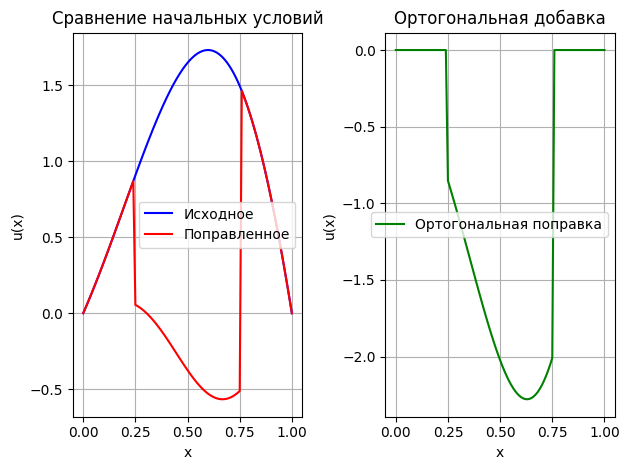

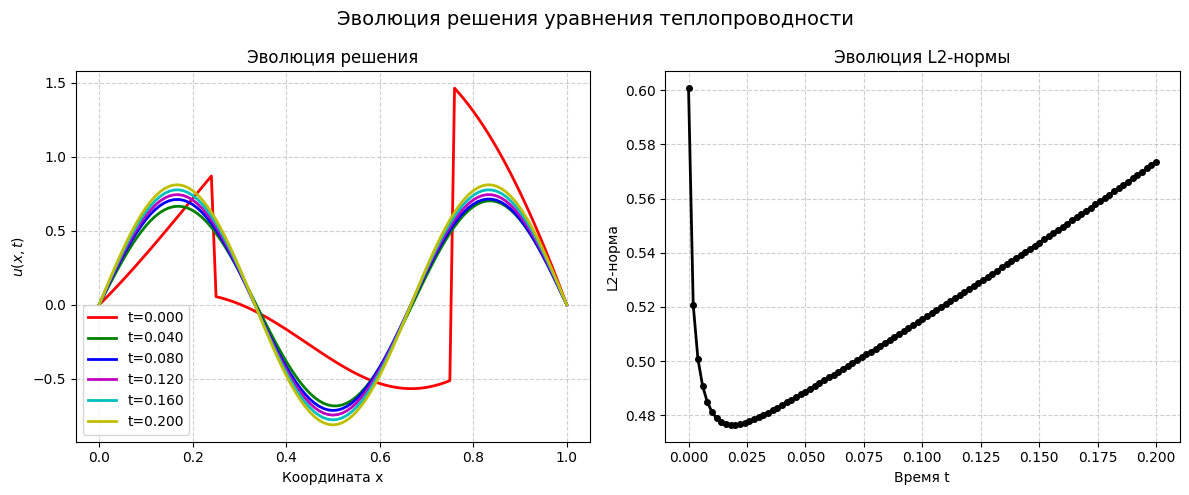

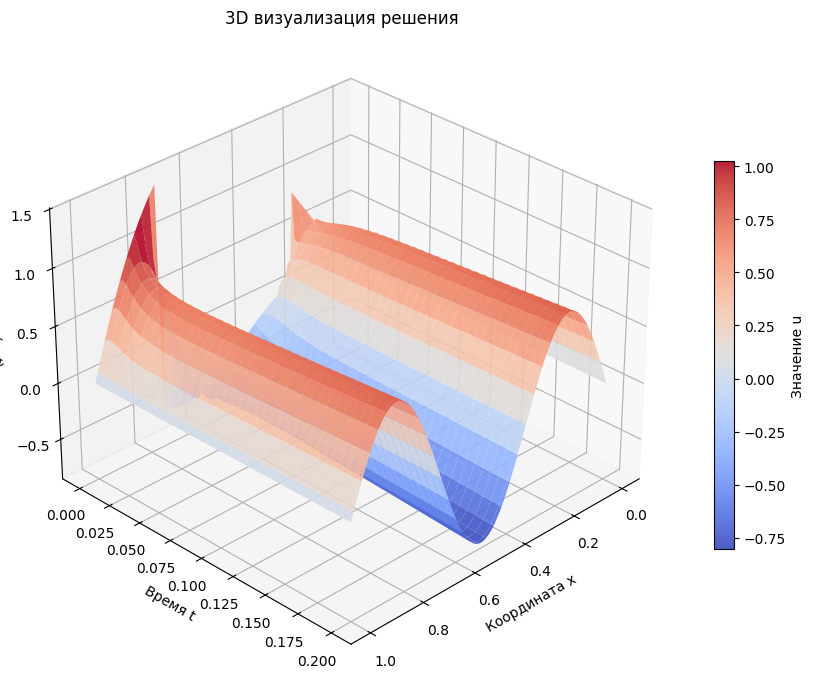

In [44]:
# Параметры
T = 1.0                 # Конечное время
L = 1.0                 # Длина области
Nt = 100                # Шаги по времени
Nx = 101                # Узлы по пространству
b = 9*np.pi*np.pi + 1   # Коэффициент в уравнении

# Создаем систему для нестабильных мод
u0_orthogonal = create_unstable_system(x, b, L)
# t, x, u = solve_heat_equation(T, L, Nt, Nx, b, orthogonal_initial_condition)

# plot_solution(t, x, u, main_title='Эволюция решения с ортогональной поправкой для b = 5*pi^2 + 1')
# Разложение по гармоникам
coeffs = decompose_into_harmonics(u0_orthogonal, x, 8, L)


# Визуализация
plt.figure()

plt.subplot(1, 2, 1)
plt.plot(x, initial_condition(x), 'b-', label='Исходное')
plt.plot(x, u0_orthogonal, 'r-', label='Поправленное')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('Сравнение начальных условий')
plt.grid(True)

plt.subplot(1, 2, 2)
addition = u0_orthogonal - initial_condition(x)
plt.plot(x, addition, 'g-', label='Ортогональная поправка')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('Ортогональная добавка')
plt.grid(True)

plt.tight_layout()
plt.show()

def plot_solution(t, x, u, main_title='Эволюция решения уравнения теплопроводности'):
  
    
    Nt = len(t) - 1
    
    # Создаем фигуру для 2D графиков
    fig1 = plt.figure(figsize=(12, 5))
    
    # 2D график - эволюция решения
    plt.subplot(1, 2, 1)
    colors = ['r-', 'g-', 'b-', 'm-', 'c-', 'y-']
    for idx, i in enumerate(range(0, Nt + 1, max(1, Nt // 5))):
        if idx < len(colors):
            plt.plot(x, u[i, :], colors[idx], linewidth=2, label=f't={t[i]:.3f}')
        else:
            plt.plot(x, u[i, :], linewidth=2, label=f't={t[i]:.3f}')
    plt.xlabel('Координата x')
    plt.ylabel('$u(x, t)$')
    plt.title('Эволюция решения')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    # L2-норма во времени
    l2_norm = np.sqrt(np.sum(u**2, axis=1) * (x[1] - x[0]))
    
    plt.subplot(1, 2, 2)
    plt.plot(t, l2_norm, 'k-', linewidth=2, marker='o', markersize=4)
    plt.xlabel('Время t')
    plt.ylabel('L2-норма')
    plt.title('Эволюция L2-нормы')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.suptitle(main_title, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Отдельная фигура для 3D визуализации
    fig2 = plt.figure(figsize=(10, 7))
    ax = fig2.add_subplot(111, projection='3d')
    
    X_grid, T_grid = np.meshgrid(x, t)
    surf = ax.plot_surface(X_grid, T_grid, u, cmap='coolwarm', 
                          alpha=0.9, antialiased=True, linewidth=0)

    ax.set_xlabel('Координата x')
    ax.set_ylabel('Время t')
    ax.set_zlabel('$u(x, t)$')
    ax.set_title('3D визуализация решения')
    ax.view_init(elev=30, azim=45)

    fig2.colorbar(surf, ax=ax, shrink=0.6, aspect=20, label='Значение u')
    
    plt.tight_layout()
    plt.show()
    
plot_solution(t, x, u, main_title='Эволюция решения уравнения теплопроводности')


Нестабильных гармоник: m = 2, k = [1, 2]


Решение: 100%|██████████| 100/100 [00:00<00:00, 8839.42it/s]


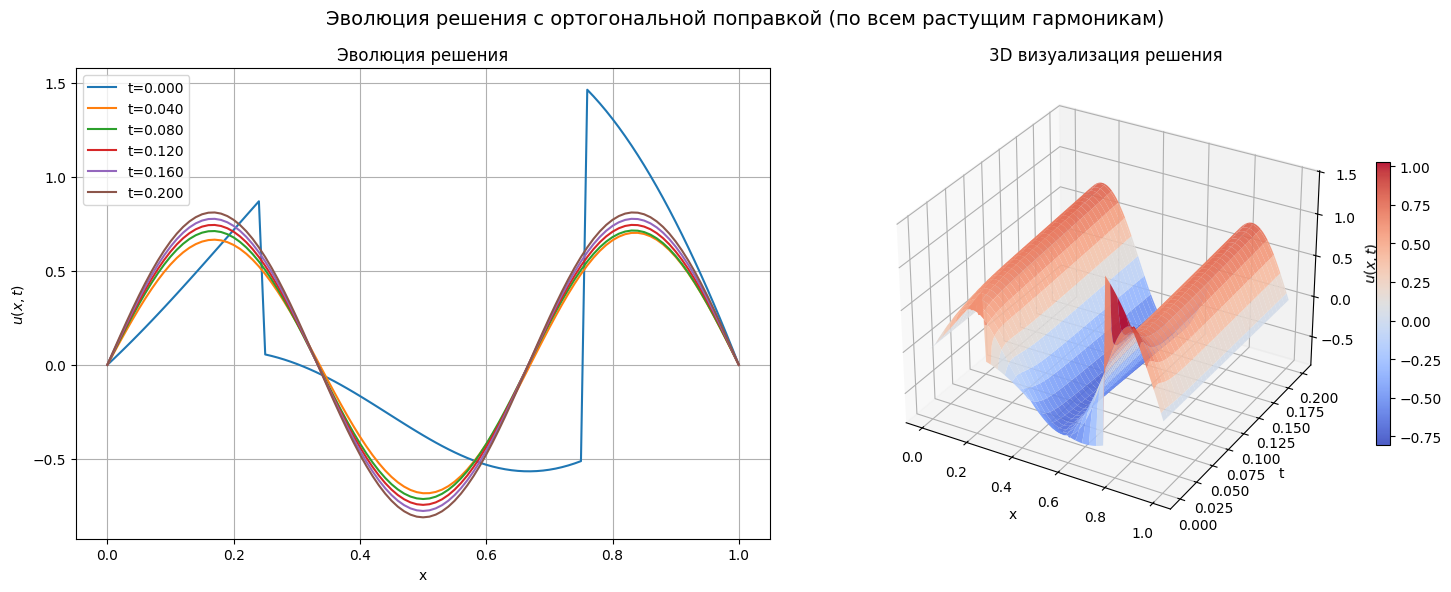

In [39]:
# Параметры
T = 0.2                 # Конечное время
L = 1.0                 # Длина области
Nt = 100                # Шаги по времени
Nx = 101                # Узлы по пространству
b = 9*np.pi*np.pi + 1   # Коэффициент в уравнении

unstable_modes = find_unstable_modes(b, 2) # 
m = len(unstable_modes)
print(f"Нестабильных гармоник: m = {m}, k = {unstable_modes}")

# Создаем добавки и базисные функции для нестабильных мод
add_conditions = [lambda x, k=k: garmonic_k(x, k) for k in unstable_modes]
basis_functions = [lambda x, k=k: np.sin(np.pi * k * x) for k in unstable_modes]

u0_orthogonal = lambda x: orthogonal_initial_condition(x, add_conditions, basis_functions, L)

t, x, u = solve_heat_equation(T, L, Nt, Nx, b, lambda x: orthogonal_initial_condition(x, add_conditions, basis_functions, L))

plot_solution(t, x, u, main_title='Эволюция решения с ортогональной поправкой (по всем растущим гармоникам)')


### Пункт 4

In [31]:
def initial_condition(x):
    """Начальное условие для задачи 4."""
    return np.sin(np.pi * x) * np.exp(x)

def get_grid(T, N, L, M):
    """Создание равномерной сетки."""
    x = np.linspace(0, L, M+1)
    t = np.linspace(0, T, N+1)
    h = x[1] - x[0]
    tau = t[1] - t[0]
    return x, t, h, tau

def solve_non_selfadjoint(u0_func, b, L, M, T, N, a):
    """
    Решение уравнения u_t = u_xx + a*u_x + b*u.
    
    Args:
        u0_func: функция начального условия
        b: параметр источника
        L: длина области
        M: число пространственных узлов
        T: время моделирования
        N: число временных шагов
        a: параметр конвекции
    """
    x, t, h, tau = get_grid(T, N, L, M)
    
    u = np.zeros((N + 1, M + 1))
    
    if callable(u0_func):
        u[0, :] = u0_func(x)
    else:
        u[0, :] = u0_func
    
    u[0, 0] = 0
    u[0, -1] = 0
    
    inner_M = M - 1
    
    coeff_diag = 1/tau - b + 2/(h**2)
    coeff_side = -1/(h**2)
    coeff_conv = a/(2*h)
    
    diag_a = np.full(inner_M, coeff_side + coeff_conv)
    diag_b = np.full(inner_M, coeff_diag)
    diag_c = np.full(inner_M, coeff_side - coeff_conv)
    
    for n in range(N):
        rhs = (1/tau) * u[n, 1:-1]
        u_inner = thomas_algorithm(diag_a, diag_b, diag_c, rhs)
        u[n+1, 1:-1] = u_inner
        u[n+1, 0] = 0
        u[n+1, -1] = 0
    
    return u, x, t

def build_operator_matrix(N, h, a, b):
    """Строит матрицу оператора L = d²/dx² + a*d/dx + b."""
    alpha = 1 / h**2
    beta = a / (2 * h)
    
    c_minus = alpha - beta
    c_main = b - 2*alpha
    c_plus = alpha + beta
    
    L_mat = np.zeros((N, N))
    
    for i in range(N):
        L_mat[i, i] = c_main
        if i > 0:
            L_mat[i, i-1] = c_minus
        if i < N-1:
            L_mat[i, i+1] = c_plus
    
    return L_mat

def compute_biorthogonal_basis(L_mat, h):
    """Вычисляет биортогональный базис для несамосопряжённого оператора."""
    # v - правые собственные векторы
    lambdas, v = np.linalg.eig(L_mat)
    
    # w - левые собственные векторы
    lambdas_w, w_temp = np.linalg.eig(L_mat.T)
    
    idx = np.argsort(lambdas.real)[::-1] # cсортируем по убыванию
    lambdas = lambdas[idx]
    v = v[:, idx]
    
    w = np.zeros_like(w_temp, dtype=complex)
    for i, val in enumerate(lambdas):
        dist = np.abs(lambdas_w - val)
        j = np.argmin(dist)
        w[:, i] = w_temp[:, j]
    
    for i in range(L_mat.shape[0]):
        dot_prod = np.sum(v[:, i] * w[:, i]) * h
        if np.abs(dot_prod) > 1e-12:
            w[:, i] /= dot_prod
    
    return lambdas, v, w

def find_unstable_indices(lambdas, threshold=0.0):
    """Находит индексы неустойчивых гармоник (Re(λ) > threshold)."""
    return [i for i, lam in enumerate(lambdas) if np.real(lam) > threshold]

def create_stabilized_initial_condition(x, L_mat, h, a, b):
    """Создаёт стабилизированное начальное условие."""
    lambdas, v, w = compute_biorthogonal_basis(L_mat, h)
    
    unstable_idx = find_unstable_indices(lambdas)
    m_unstable = len(unstable_idx)
    
    print(f"Найдено {m_unstable} неустойчивые гармоники")
    print(f"Собственные значения неустойчивых гармоник:")
    for idx in unstable_idx:
        print(f"  λ_{idx} = {lambdas[idx].real:.4f} + {lambdas[idx].imag:.4f}i")
    
    if m_unstable == 0:
        print("Система устойчива, модификация не требуется.")
        return initial_condition(x), [], [], [], []
    
    x_inner = x[1:-1]
    u0_inner = initial_condition(x_inner)
    mask = (x_inner >= 0.25) & (x_inner <= 0.75)
    
    G_matrix = np.zeros((m_unstable, m_unstable), dtype=complex)
    rhs_vec = np.zeros(m_unstable, dtype=complex)
    
    for i in range(m_unstable):
        idx_i = unstable_idx[i]
        w_vec = w[:, idx_i]
        rhs_vec[i] = -np.sum(u0_inner * w_vec) * h
        
        for j in range(m_unstable):
            idx_j = unstable_idx[j]
            v_vec_cut = np.zeros_like(v[:, idx_j])
            v_vec_cut[mask] = v[mask, idx_j]
            G_matrix[i, j] = np.sum(v_vec_cut * w_vec) * h
    
    d_coeffs = np.linalg.solve(G_matrix, rhs_vec)
    
    u_corr_inner = np.zeros_like(u0_inner, dtype=complex)
    for j in range(m_unstable):
        idx_j = unstable_idx[j]
        v_vec = v[:, idx_j]
        u_corr_inner[mask] += d_coeffs[j] * v_vec[mask]
    
    u0_new = np.zeros_like(x, dtype=complex)
    u0_new[1:-1] = u0_inner + u_corr_inner.real
    u0_new[0] = 0
    u0_new[-1] = 0
    
    print("\nПроверка ортогональности нового начального условия:")
    for i in range(m_unstable):
        idx = unstable_idx[i]
        w_vec = w[:, idx]
        product = np.sum(u0_new[1:-1] * w_vec.real) * h
        print(f"<u0_new, w_{idx}> = {product:.2e}")
    
    return u0_new.real, lambdas, v, w, unstable_idx

Найдено 3 неустойчивые гармоники
Собственные значения неустойчивых гармоник:
  λ_0 = 79.8952 + 0.0000i
  λ_1 = 50.2984 + 0.0000i
  λ_2 = 1.0022 + 0.0000i

Проверка ортогональности нового начального условия:
<u0_new, w_0> = 1.41e-16+0.00e+00j
<u0_new, w_1> = 6.33e-16+0.00e+00j
<u0_new, w_2> = 1.93e-15+0.00e+00j


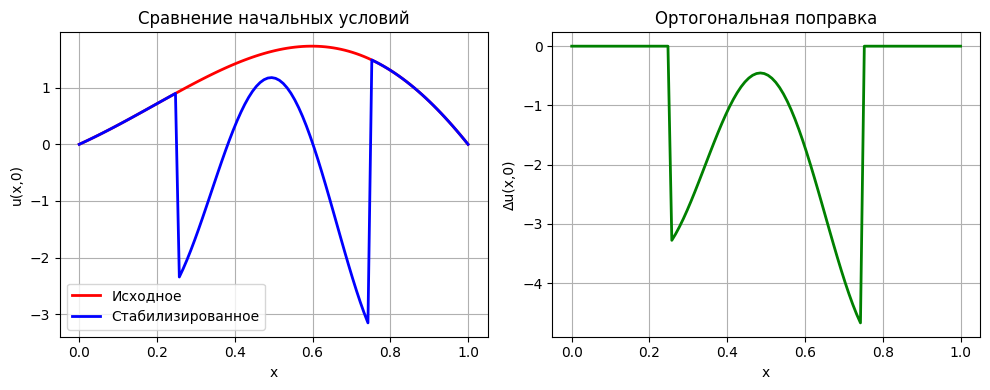

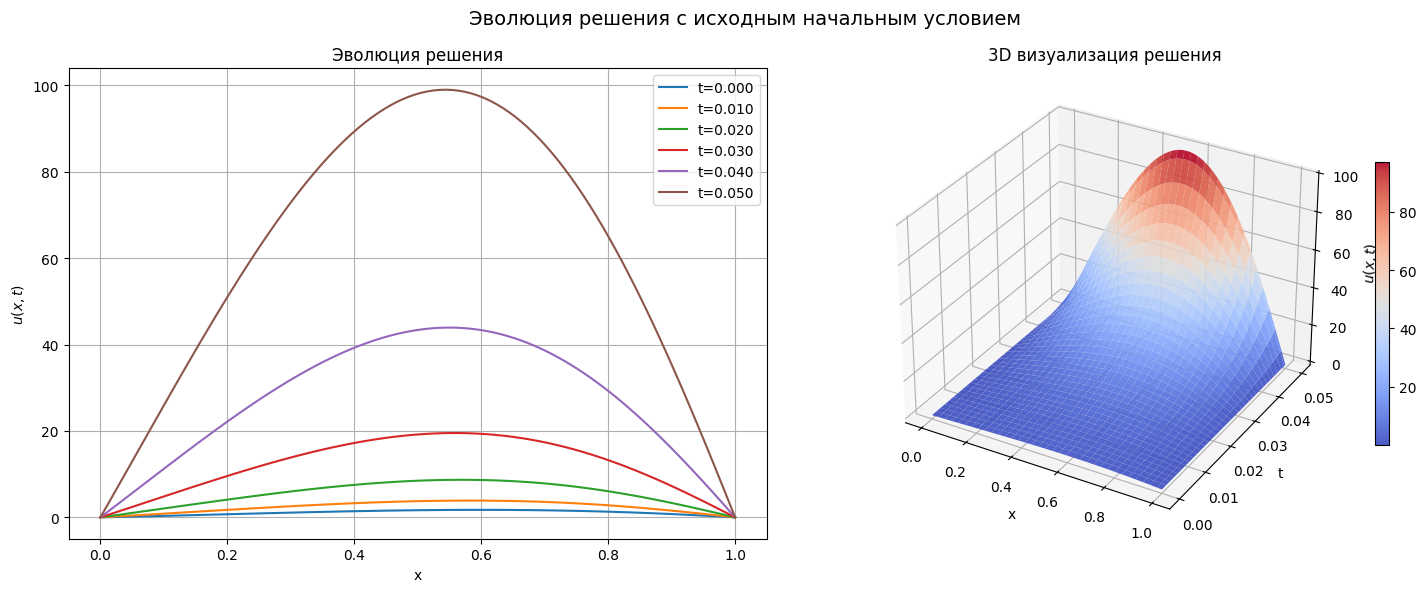

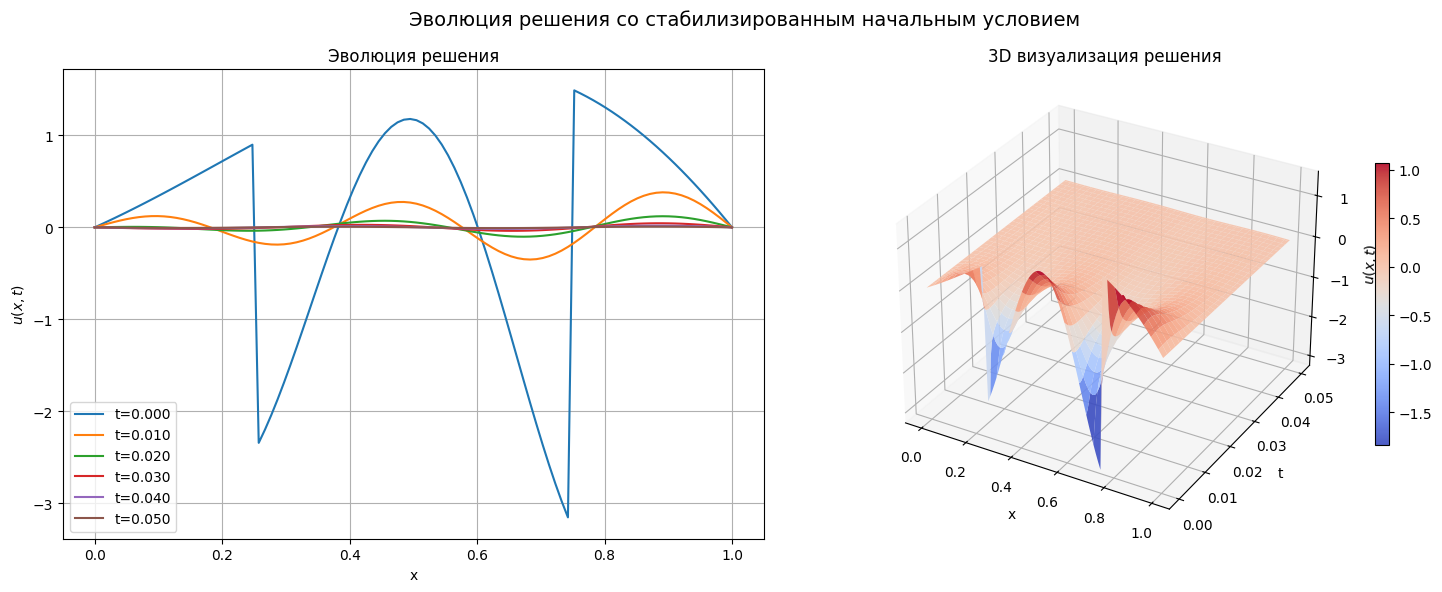

In [32]:
L = 1.0
T = 0.05
Nt = 100
Nx = 101
a = -0.5
b = 9 * np.pi**2 + 1

# Создание сетки
x, t, h, tau = get_grid(T, Nt, L, Nx)

#  Строим матрицу оператора
m_inner = Nx - 1
L_mat = build_operator_matrix(m_inner, h, a, b)

# Создаём стабилизированное начальное условие
u0_stabilized, lambdas, v, w, unstable_idx = create_stabilized_initial_condition(
    x, L_mat, h, a, b
)

# Решаем уравнение с исходным начальным условием
u_orig, x_orig, t_orig = solve_non_selfadjoint(
    initial_condition, b, L, Nx, T, Nt, a
)

# Решаем уравнение со стабилизированным начальным условием
u_stab, x_stab, t_stab = solve_non_selfadjoint(
    u0_stabilized, b, L, Nx, T, Nt, a
)

#Сравнение начальных условий
plt.figure(figsize=(10, 4))

# Первый график: сравнение начальных условий
plt.subplot(1, 2, 1)
plt.plot(x, initial_condition(x), 'r-', linewidth=2, label='Исходное')
plt.plot(x, u0_stabilized, 'b-', linewidth=2, label='Стабилизированное')
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.title('Сравнение начальных условий')
plt.legend()
plt.grid(True)

# Второй график: ортогональная поправка
plt.subplot(1, 2, 2)
correction = u0_stabilized - initial_condition(x)
plt.plot(x, correction, 'g-', linewidth=2)
plt.xlabel('x')
plt.ylabel('Δu(x,0)')
plt.title('Ортогональная поправка')
plt.grid(True)

plt.tight_layout()
plt.show()

# Сравнение решений
plot_solution(t_orig, x_orig, u_orig, 
                main_title='Эволюция решения с исходным начальным условием')

plot_solution(t_stab, x_stab, u_stab, 
                main_title='Эволюция решения со стабилизированным начальным условием')


### ПУНКТ 5

In [33]:
def solve_nonlinear_equation(u0_func, b, L, M, T, N, a):
    """
    Решение нелинейного уравнения u_t = u_xx + a*u_x + b*u + u^3.
    Используется полунеявная схема: линейная часть неявно, нелинейная - явно.
    """
    x, t, h, tau = get_grid(T, N, L, M)
    
    u = np.zeros((N + 1, M + 1))
    
    if callable(u0_func):
        u[0, :] = u0_func(x)
    else:
        u[0, :] = u0_func
    
    u[0, 0] = 0
    u[0, -1] = 0
    
    inner_M = M - 1
    
    # Коэффициенты для линейной части (неявно)
    coeff_diag = 1/tau - b + 2/(h**2)
    coeff_side = -1/(h**2)
    coeff_conv = a/(2*h)
    
    diag_a = np.full(inner_M, coeff_side + coeff_conv)
    diag_b = np.full(inner_M, coeff_diag)
    diag_c = np.full(inner_M, coeff_side - coeff_conv)
    
    # Временной цикл
    for n in range(N):
        # Правая часть: u^n/τ + (u^n)^3 (полунеявная схема)
        nonlinear_term = tau * (u[n, 1:-1] ** 3)
        rhs = (1/tau) * u[n, 1:-1] + nonlinear_term
        
        # Решаем СЛАУ: (I - τL)u^{n+1} = u^n + τ*(u^n)^3
        u_inner = thomas_algorithm(diag_a, diag_b, diag_c, rhs)
        
        u[n+1, 1:-1] = u_inner
        u[n+1, 0] = 0
        u[n+1, -1] = 0
    
    return u, x, t

def plot_initial_conditions_comparison(x, u0_orig, u0_stab):
    """Сравнение начальных условий."""
    correction = u0_stab - u0_orig
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, u0_orig, 'r-', linewidth=2, label='Исходное')
    plt.plot(x, u0_stab, 'b-', linewidth=2, label='Стабилизированное')
    plt.xlabel('x')
    plt.ylabel('u(x,0)')
    plt.title('Сравнение начальных условий')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(x, correction, 'g-', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('Δu(x,0)')
    plt.title('Ортогональная поправка')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()



Найдено 3 неустойчивые гармоники
Собственные значения неустойчивых гармоник:
  λ_0 = 79.8952 + 0.0000i
  λ_1 = 50.2984 + 0.0000i
  λ_2 = 1.0022 + 0.0000i

Проверка ортогональности нового начального условия:
<u0_new, w_0> = 1.41e-16+0.00e+00j
<u0_new, w_1> = 6.33e-16+0.00e+00j
<u0_new, w_2> = 1.93e-15+0.00e+00j


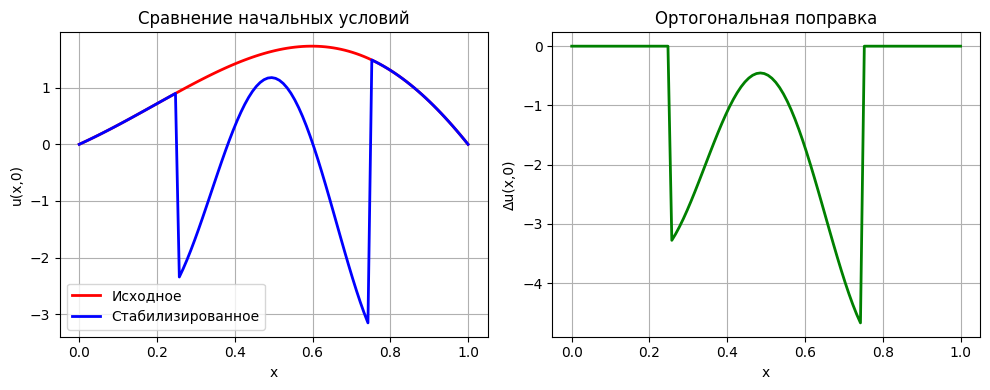


Детальная визуализация нелинейных решений:


/var/folders/j7/ms50hmkx4sxgmqrwysp2jpgm0000gn/T/ipykernel_63149/253435873.py:32: RuntimeWarning: overflow encountered in power
  nonlinear_term = tau * (u[n, 1:-1] ** 3)


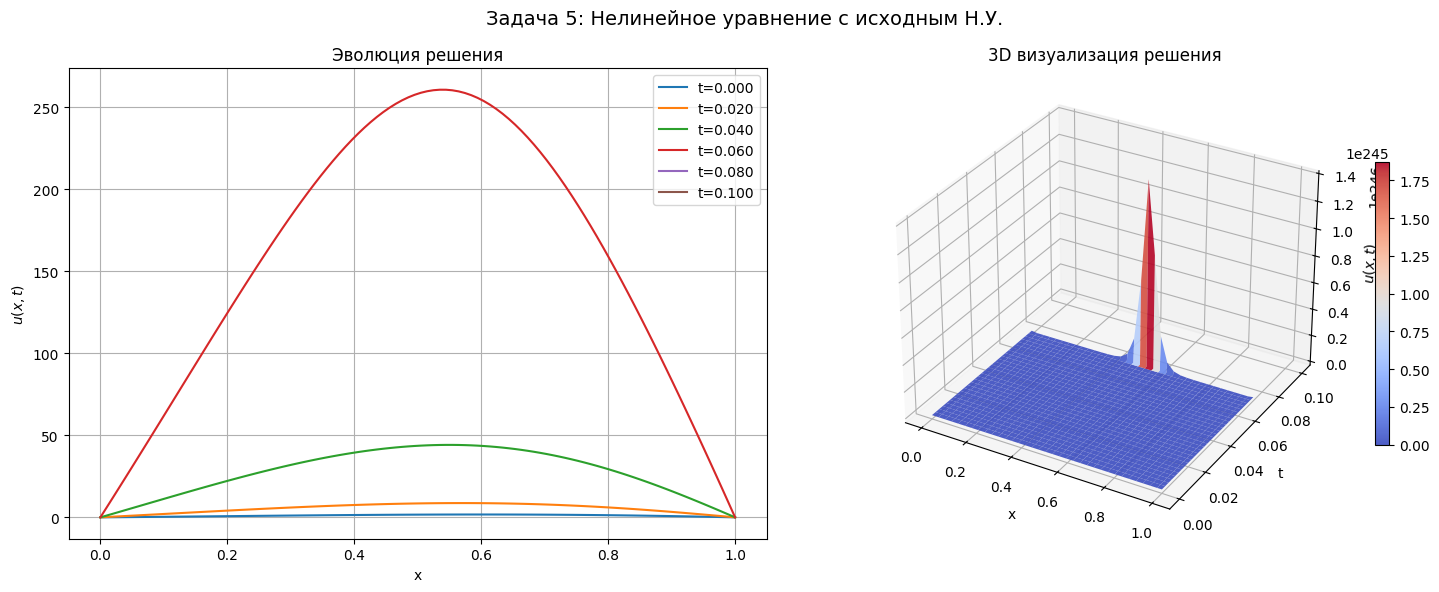

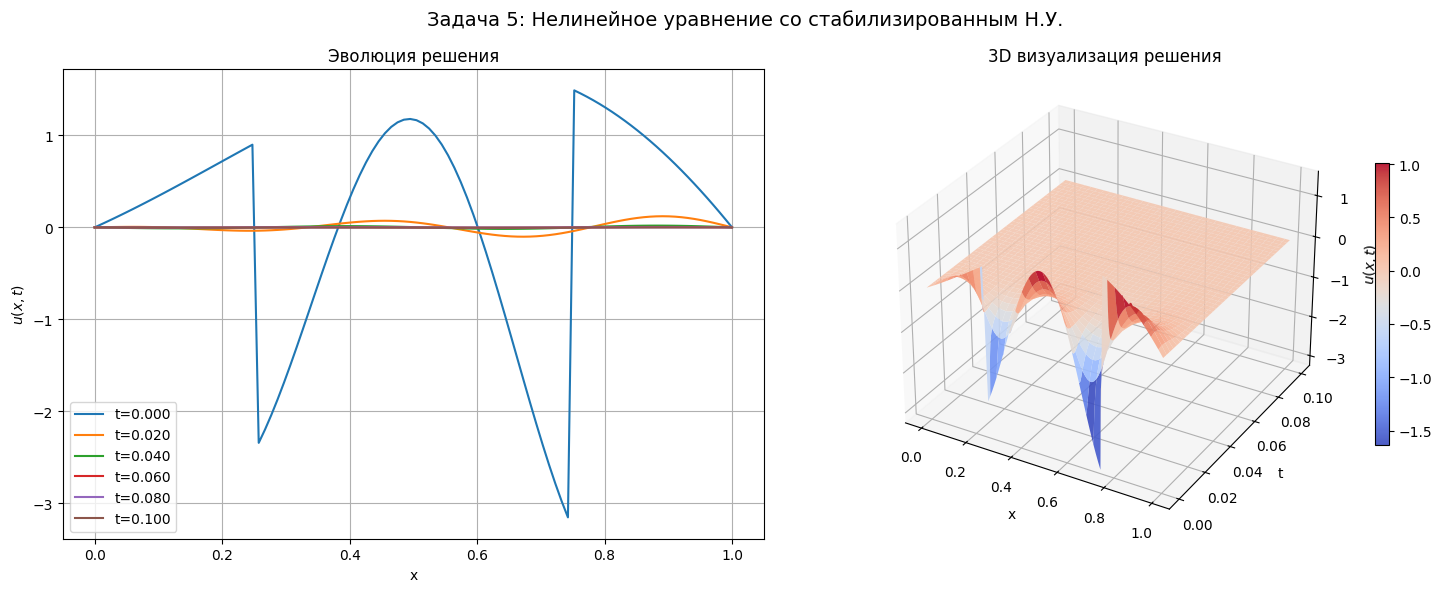

In [34]:
L = 1.0
T = 0.1 
Nt = 200
Nx = 101
a = -0.5
b = 9 * np.pi**2 + 1

# Создание сетки
x, t, h, tau = get_grid(T, Nt, L, Nx)


m_inner = Nx - 1
L_mat = build_operator_matrix(m_inner, h, a, b)
u0_stabilized, lambdas, v, w, unstable_idx = create_stabilized_initial_condition(
    x, L_mat, h, a, b
)

# Визуализация начальных условий
plot_initial_conditions_comparison(x, initial_condition(x), u0_stabilized)

# Решаем линейное уравнение c исходным НУ

u_orig_linear, x_linear, t_linear = solve_non_selfadjoint(
    initial_condition, b, L, Nx, T, Nt, a
)

# Решаем линейное уравнение cо стабилизированным НУ

u_stab_linear, x_linear, t_linear = solve_non_selfadjoint(
    u0_stabilized, b, L, Nx, T, Nt, a
)
# Решаем нелинейное уравнение с исходным НУ

u_orig_nonlinear, x_nonlinear, t_nonlinear = solve_nonlinear_equation(
    initial_condition, b, L, Nx, T, Nt, a
)

# Решаем нелинейное уравнение со стабилизированным НУ

u_stab_nonlinear, x_nonlinear, t_nonlinear = solve_nonlinear_equation(
    u0_stabilized, b, L, Nx, T, Nt, a
)

# 4.3. Детальная визуализация нелинейных решений
print("\nДетальная визуализация нелинейных решений:")
plot_solution(t_nonlinear, x_nonlinear, u_orig_nonlinear, 
                main_title='Задача 5: Нелинейное уравнение с исходным Н.У.')

plot_solution(t_nonlinear, x_nonlinear, u_stab_nonlinear, 
                main_title='Задача 5: Нелинейное уравнение со стабилизированным Н.У.')

